# Introduction

ARIMA models are, in theory, the most general class of models for forecasting a time series, which can be made to be “stationary” by differencing (if necessary), perhaps in conjunction with nonlinear transformations such as logging or deflating (if necessary). A random variable that is a time series is stationary if its statistical properties are all constant over time. A stationary series has no trend, its variations around its mean have a constant amplitude, and it wiggles in a consistent fashion, i.e., its short-term random time patterns always look the same in a statistical sense. The latter condition means that its autocorrelations (correlations with its prior deviations from the mean) remain constant over time, or equivalently, that its power spectrum remains constant over time. A random variable of this form can be viewed (as usual) as a combination of signal and noise, and the signal (if one is apparent) could be a pattern of fast or slow mean reversion, or sinusoidal oscillation, or rapid alternation in sign, and it could also have a seasonal component. An ARIMA model can be viewed as a “filter” that tries to separate the signal from the noise, and the signal is then extrapolated into the future to obtain forecasts.

# The Data

The data we will use is annual sunspot data from 1700 – 2008 recording the number of sunspots per year. The file sunspots.csv and can be downloaded from the line below.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

In [2]:
df=pd.read_csv("sunspots.csv")
df.head(None)

,YEAR,SUNACTIVITY
0,1700,5.0
1,1701,11.0
2,1702,16.0
3,1703,23.0
4,1704,36.0
...,...,...
304,2004,40.4
305,2005,29.8
306,2006,15.2
307,2007,7.5


In [3]:
df.shape

(309, 2)

In [4]:
pwd()

'C:\\Users\\asus'

In [5]:
df.index=pd.Index(sm.tsa.datetools.dates_from_range("1700","2008"))
del df["YEAR"]

In [6]:
df

,SUNACTIVITY
1700-12-31,5.0
1701-12-31,11.0
1702-12-31,16.0
1703-12-31,23.0
1704-12-31,36.0
...,...
2004-12-31,40.4
2005-12-31,29.8
2006-12-31,15.2
2007-12-31,7.5


<AxesSubplot:>

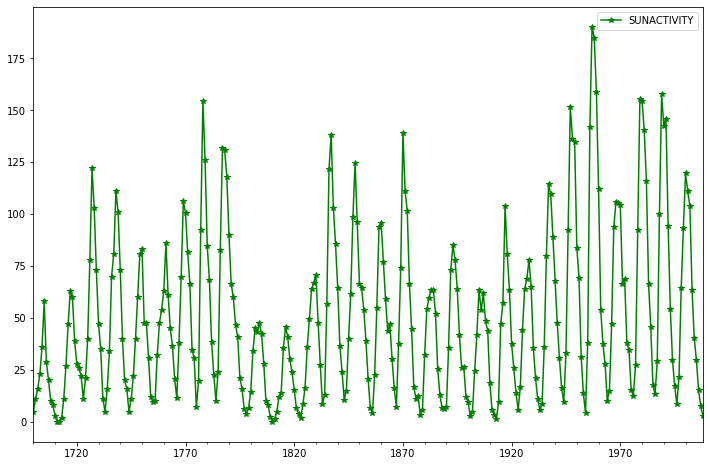

In [7]:
df.plot(figsize=(12,8), color="g",marker="*")

In [8]:
df1=pd.read_csv("daily-total-female-births-CA.csv")
df1.head(None)

,date,births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44
...,...,...
360,1959-12-27,37
361,1959-12-28,52
362,1959-12-29,48
363,1959-12-30,55


# Auto-correlations

Before we decide which model to use, we need to look at auto-correlations.

#### Autocorrelation correlogram. 
Seasonal patterns of time series can be examined via correlograms, which display graphically and numerically the autocorrelation function (ACF). Auto-correlation in pandas plotting and statsmodels graphics standardize the data before computing the auto-correlation. These libraries subtract the mean and divide by the standard deviation of the data.

When using standardization, they make an assumption that your data has been generated with a Gaussian law (with a certain mean and standard deviation). This may not be the case in reality.

Correlation is sensitive. Both (matplotlib and pandas plotting) of these functions have their drawbacks. The figure generated by the following code using matplotlib will be identical to figure generated by pandas plotting or statsmodels graphics.

#### Partial autocorrelations. 
Another useful method to examine serial dependencies is to examine the partial autocorrelation function (PACF) – an extension of autocorrelation, where the dependence on the intermediate elements (those within the lag) is removed.

Once we determine the nature of the auto-correlations we use the following rules of thumb.

   * Rule 1: If the ACF shows exponential decay, the PACF has a spike at lag 1, and no correlation for other lags, then use one autoregressive (p)parameter
   * Rule 2: If the ACF shows a sine-wave shape pattern or a set of exponential decays, the PACF has spikes at lags 1 and 2, and no correlation for other lags, the use two autoregressive (p) parameters
   * Rule 3: If the ACF has a spike at lag 1, no correlation for other lags, and the PACF damps out exponentially, then use one moving average (q) parameter.
   * Rule 4: If the ACF has spikes at lags 1 and 2, no correlation for other lags, and the PACF has a sine-wave shape pattern or a set of exponential decays, then use two moving average (q) parameter.
   * Rule 5: If the ACF shows exponential decay starting at lag 1, and the PACF shows exponential decay starting at lag 1, then use one autoregressive (p) and one moving average (q) parameter.
   
#### Removing serial dependency. 
Serial dependency for a particular lag can be removed by differencing the series. There are two major reasons for such transformations.

   * First, we can identify the hidden nature of seasonal dependencies in the series. Autocorrelations for consecutive lags are interdependent, so removing some of the autocorrelations will change other auto correlations, making other seasonalities more apparent.
   * Second, removing serial dependencies will make the series stationary, which is necessary for ARIMA and other techniques.


Another popular test for serial correlation is the Durbin-Watson statistic. The DW statistic will lie in the 0-4 range, with a value near two indicating no first-order serial correlation. Positive serial correlation is associated with DW values below 2 and negative serial correlation with DW values above 2

In [9]:
sm.stats.durbin_watson(df)

array([0.13952893])

The value of Durbin_ watson is close to 2 if the errors are uncorrelated. In our example it is 0.1395. That means that there is a strong evidence that the variable open has high autocorrelation.

In [10]:
import warnings
warnings.filterwarnings("ignore")

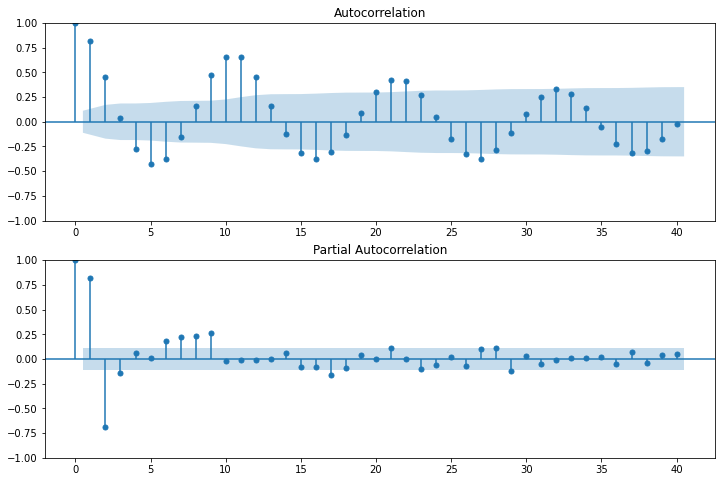

In [11]:
fig= plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=40, ax=ax1)
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(df,lags=40,ax=ax2)

The acf and pacf is not calculated based on the existing data but they are calculated internally by standardizing the data.

The above plots also indicate that autocorrelation is present . Another set of plots(showing below) are available using the autocorrelation_plot function from pandas.

In [12]:
from pandas.plotting  import autocorrelation_plot
df["SUNACTIVITY_2"]=df["SUNACTIVITY"]

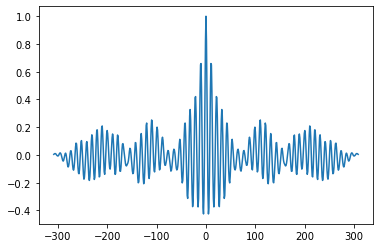

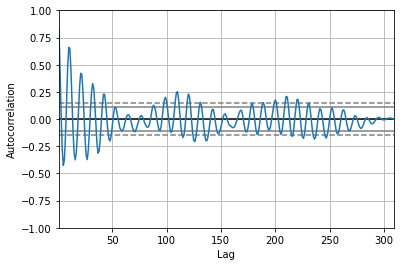

In [13]:
df["SUNACTIVITY_2"]=(df["SUNACTIVITY_2"]-df["SUNACTIVITY"].mean())/(df["SUNACTIVITY_2"].std())
plt.acorr(df["SUNACTIVITY_2"],maxlags=len(df["SUNACTIVITY_2"])-1, linestyle="solid", usevlines=False, marker=" ")
plt.show()
autocorrelation_plot(df["SUNACTIVITY"])
plt.show()

For mixed ARMA processes the Autocorrelation function is a mixture of exponentials and damped sine waves after (q-p) lags. The partial autocorrelation function is a mixture of exponentials and dampened sine waves after (p-q) lags.

# Times Series Modeling
We will only explore two methods here. An ARMA model is classified as ARMA(p,q), with no differenceing terms. ARMA models can be described by a series of equations. The equations are somewhat simpler if the time series is first reduced to zero-mean by subtracting the sample mean. Therefore, we will work with the mean-adjusted series

    yt = Yt – Y̅, t = 1, …N

where Yt is the original time series, Y̅ is its sample mean, and yt is the mean-adjusted series. One subset of ARMA models are the so-called autoregressive, or AR models. An AR model expresses a time series as a linear function of its past values. The order of the AR model tells how many lagged past values are included. The simplest AR model is the first-order autoregressive, or AR(1), model

    yt + a1 yt-1 = et

where yt is the mean-adjusted series in year t, yt-1 is the series in the previous year, at is the lag-1 autoregressive coefficient, and et is the noise. The noise also goes by various other names: the error, the random-shock, and the residual. The residuals et are assumed to be random in time (not autocorrelated), and normally distributed. Be rewriting the equation for the AR(1) model as

    yt = a1 yt-1 + et

We see that the AR(1) model has the form of a regression model in which yt is regressed on its previous value. In this form, at is analogous to the negative of the regression coefficient, and et to the regression residuals. The name autoregressive refers to the regression on self (auto).

A nonseasonal ARIMA model is classified as an ARIMA(p,d,q) model, where:

   * p is the number of autoregressive terms,
   * d is the number of nonseasonal differences needed for stationarity, and
   * q is the number of lagged forecast errors in the prediction equation.
   
The forecasting equation is constructed as follows. First, let y denote the dth difference of Y, which means:

    If d=0: yt = Yt

    If d=1: yt = Yt – Yt-1

    If d=2: yt = (Yt – Yt-1) – (Yt-1 – Yt-2) = Yt – 2Yt-1 + Yt-2

Note that the second difference of Y (the d=2 case) is not the difference from two periods ago. Rather, it is the first-difference-of-the-first difference, which is the discrete analog of a second derivative, i.e., the local acceleration of the series rather than its local trend.


In [14]:
from statsmodels.tsa.arima.model import ARIMA

In [15]:
df.shape

(309, 2)

In [16]:
df.isnull().sum()

SUNACTIVITY      0
SUNACTIVITY_2    0
dtype: int64

In [17]:
df.head()

,SUNACTIVITY,SUNACTIVITY_2
1700-12-31,5.0,-1.106285
1701-12-31,11.0,-0.957963
1702-12-31,16.0,-0.834362
1703-12-31,23.0,-0.661320
1704-12-31,36.0,-0.339956


In [18]:
#order: The (p,d,q) order of the model for the autoregressive, differences, and moving average components
model_fit = ARIMA(df['SUNACTIVITY'], order=(2,0,1)).fit()
round(model_fit.params,2)

const      49.75
ar.L1       1.47
ar.L2      -0.76
ma.L1      -0.15
sigma2    270.88
dtype: float64

We now calculate the Akaike Information Criterion (AIC), Schwarz Bayesian Information Criterion (BIC), and Hannan-Quinn Information Criterion (HQIC). Our goals to choose a model that minimizes (AIC, BIC, HQIC).


In [19]:
model_fit.aic, model_fit.bic, model_fit.hqic

(2620.2771925520847, 2638.9438989365735, 2627.740177358642)

Does our model obey the theory? We will use the Durbin-Watson test for autocorrelation. The Durbin-Watson statistic ranges in value from 0 to 4. A value near 2 indicates non-autocorrelation; a value toward 0 indicates positive autocorrelation; a value toward 4 indicates negative autocorrelation.

In [20]:
sm.stats.durbin_watson(model_fit.resid.values)

1.9903374307271897

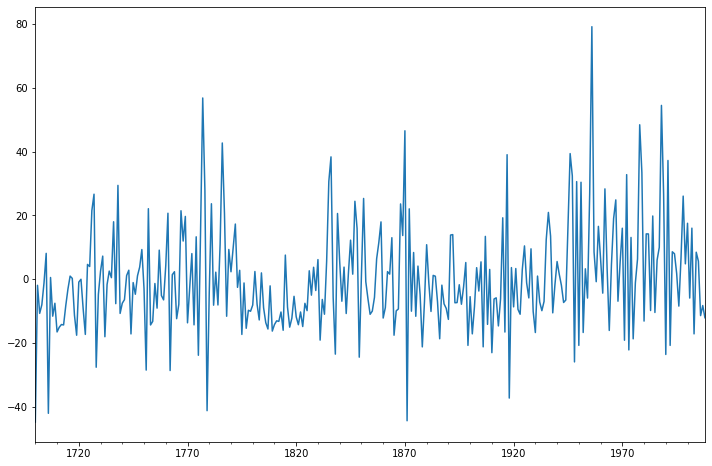

In [21]:
fig= plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)
ax=model_fit.resid.plot(ax=ax)


The Durbin Watson test result shows no autocorrelation.

In [22]:
import statistics

In [23]:
resid1= model_fit.resid

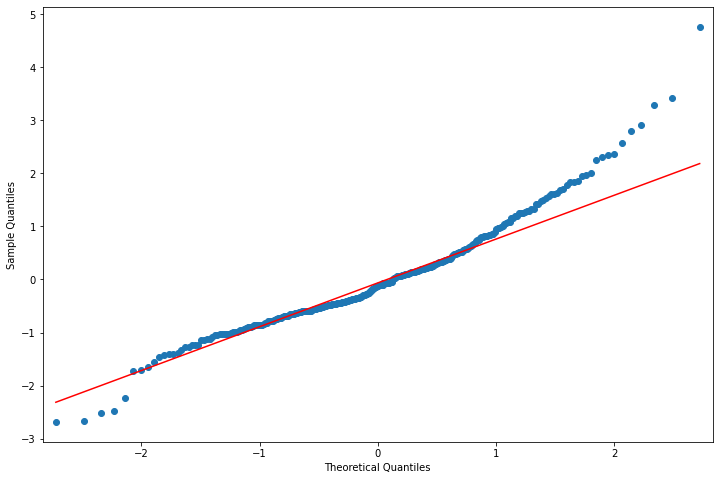

In [24]:
fig= plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)
ax=qqplot(resid1,ax=ax,line="q", fit=True)

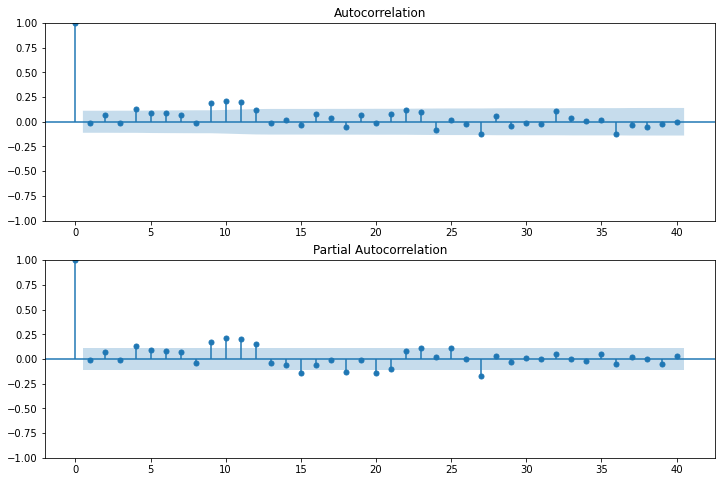

In [25]:
fig= plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(resid1.values.squeeze(), lags=40, ax=ax1)
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(resid1,lags=40,ax=ax2)

In [26]:
predict_sunsplot=model_fit.predict("2002","2012",dynamic=True)
print(predict_sunsplot)

2002-12-31    87.995421
2003-12-31    59.748470
2004-12-31    35.575759
2005-12-31    21.353835
2006-12-31    18.690407
2007-12-31    25.512482
2008-12-31    37.557210
2009-12-31    50.120398
2010-12-31    59.502366
2011-12-31    63.814078
2012-12-31    63.070962
Freq: A-DEC, Name: predicted_mean, dtype: float64


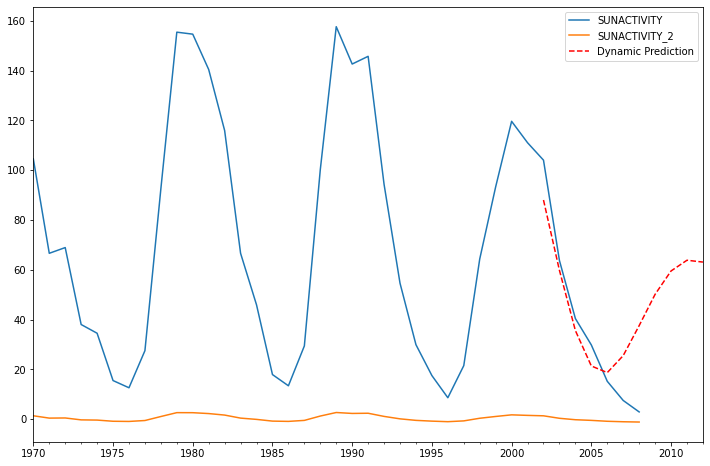

In [27]:
ax=df.loc["1970":].plot(figsize=(12,8))
ax=predict_sunsplot.plot(ax=ax,style="r--",label="Dynamic Prediction")
ax.legend()

#Calculate the forecasted errors.

##### Mean absoulate error: 
The MAE value is computed as the average absoulate error value. IF this is 0, the fit(forecast) is prefect. As compared to the mean squared error value, this measure of fit will de-emphasize outliers, that is, unique or rare large error values will affect the MAE less than the MSE values.

##### Mean Forecast error (Bias): 
The MFE is the average error in the observations, A large MFE means that the forecast is undershooting the actual observation, and a large negative MFE means the forecast is overshooting the actual observation. A value near to 0 is ideal.

The MAE is the better indicator of fit than MFE.

In [28]:
def mean_forecast_error(y,yhat):
    return y.sub(yhat).mean()
def mean_absolute_error(y, yhat):
    return np.mean((np.abs(y.sub(yhat).mean())/yhat))

In [29]:
print("MFE", mean_forecast_error(df.SUNACTIVITY, predict_sunsplot))
print("MAE", mean_absolute_error(df.SUNACTIVITY, predict_sunsplot))

MFE -3.2762262584087134
MAE 0.08656674405938988


For MFE>0, models tends to underforecast. However as long as the tracking signal is between -4 to 4, we assume the model is working correctly. The measure of MAE being small would indicate a pretty good fit.